In [1]:
import numpy as np
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data generators and model specifications

## X
X is generated and normalized as in low dimension case.

In [2]:
p = 200 # number of dimension
N = 50 # sample size
rho = 0 # correlation between features

In [3]:
X = np.load('./data/X_rho0_N50_p200.npy')

## Sparse linear model
$\gamma_j \sim Bernoulli(\theta)$ (We fix $\theta=0.05$ currently, but we can also add a prior on $\theta$ later.)\
$\beta_j | \gamma_j=1 \sim U(-3,3), P(\beta_j=0|\gamma_j=0)=1$\
$Y=X\beta+\epsilon,\epsilon_i\sim N(0,\sigma^2)$




In [4]:
class Generator(object):
    def __init__(self, p, theta, beta_range, N, X) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.N = N
        self.X = X
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.N)
        return gamma, beta, Y 

In [5]:
generator = Generator(p, 0.05, (-3,3), N, X)

Generate observation

In [110]:
rng.seed(0)
gamma0, beta0, Y0 = generator.generate_samples(1)
gamma0 = gamma0.reshape(p, 1)
beta0 = beta0.reshape(p, 1)
Y0_catXY = np.concatenate((Y0, Y0@X), axis=1)

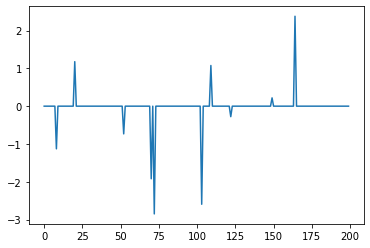

In [7]:
plt.plot(range(p),beta0)
plt.show()

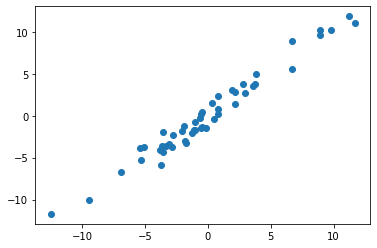

In [8]:
plt.plot(Y0.reshape(-1), X@beta0,'o')
plt.show()

Generate training and validation set

In [9]:
rng.seed(1)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)
Y_catXY_train = np.concatenate((Y_train, Y_train@X), axis=1)
Y_catXY_val = np.concatenate((Y_val, Y_val@X), axis=1)

Standardization \
The mean and standard deviation are computed using the 1,000,000 training samples.

In [10]:
mean = Y_train.mean(0)
mean_catXY = Y_catXY_train.mean(0)
std = Y_train.std(0)
std_catXY = Y_catXY_train.std(0)
Y_train = (Y_train - mean) / std
Y_val = (Y_val - mean) / std
Y_catXY_train = (Y_catXY_train - mean_catXY) / std_catXY
Y_catXY_val = (Y_catXY_val - mean_catXY) / std_catXY

In [36]:
rng.seed(212)
gamma_test, beta_test, Y_test = generator.generate_samples(10000)
Y_catXY_test = np.concatenate((Y_test, Y_test@X), axis=1)
Y_test = (Y_test - mean) / std 
Y_catXY_test = (Y_catXY_test - mean_catXY) / std_catXY

# Neural network functions

## Four layers MLP
* Four hidden layers, with 1024, 2048, 2048 and 1024 hidden units.

In [55]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 
    
    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss 

## Training functions

In [39]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q):
    model.train()
    n = train_data.shape[0]
    train_loss = 0.
    for i in range(math.ceil(n/batch_size)):
        data = torch.from_numpy(train_data[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        targ = torch.from_numpy(train_labels[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n 

def model_test(model, test_data, test_labels, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
    return loss.item()

def train_model(model, lr, batch_size, epochs, train_data, train_labels, loss_type='mse', q=0.5, val_data=None, val_labels=None, early_stop=5):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if es_count >= early_stop:
                break
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [13]:
''' 
Every batch use brand new data. Every sample is used only one time.
'''
def train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, catXY):
    model.train()
    train_loss = 0.
    for i in range(iteration):
        gamma, beta, Y = generator.generate_samples(batch_size)
        if catXY:
            Y = np.concatenate((Y, Y@X), axis=1)
            Y = (Y - mean_catXY) / std_catXY
        else:
            Y = (Y - mean) / std
        gamma = torch.from_numpy(gamma).type(torch.float).to(device)
        beta = torch.from_numpy(beta).type(torch.float).to(device)
        Y = torch.from_numpy(Y).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(Y, beta)
        elif loss_type == 'bce':
            loss = model.get_bceloss(Y, gamma)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(Y, beta, q)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/(i+1)

def train_model_with_generator(model, generator, lr, batch_size, epochs, iteration, catXY, loss_type='mse', q=0.5, val_data=None, val_labels=None):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        train_loss = train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, catXY)
        print('Epoch: {}, Train loss {:.5f}'.format(i+1, train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print("Val loss: {:.5f}".format(val_loss))
            val_losses.append(val_loss)
    return train_losses, val_losses

## Other functions

In [76]:
def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

# Main experiments

## Does including $X^TY$ in the input improve model performance?

In [13]:
torch.manual_seed(0)
md_base = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_base, 0.001, 256, 80, Y_train, beta_train, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.07121
Val loss: 0.05504
Epoch: 2
Train loss: 0.05034
Val loss: 0.05056
Epoch: 3
Train loss: 0.04719
Val loss: 0.04934
Epoch: 4
Train loss: 0.04569
Val loss: 0.04864
Epoch: 5
Train loss: 0.04466
Val loss: 0.04826
Epoch: 6
Train loss: 0.04379
Val loss: 0.04791
Epoch: 7
Train loss: 0.04299
Val loss: 0.04777
Epoch: 8
Train loss: 0.04224
Val loss: 0.04720
Epoch: 9
Train loss: 0.04148
Val loss: 0.04684
Epoch: 10
Train loss: 0.04076
Val loss: 0.04642
Epoch: 11
Train loss: 0.04000
Val loss: 0.04606
Epoch: 12
Train loss: 0.03923
Val loss: 0.04563
Epoch: 13
Train loss: 0.03844
Val loss: 0.04494
Epoch: 14
Train loss: 0.03764
Val loss: 0.04453
Epoch: 15
Train loss: 0.03677
Val loss: 0.04367
Epoch: 16
Train loss: 0.03586
Val loss: 0.04303
Epoch: 17
Train loss: 0.03487
Val loss: 0.04210
Epoch: 18
Train loss: 0.03372
Val loss: 0.04103
Epoch: 19
Train loss: 0.03261
Val loss: 0.04004
Epoch: 20
Train loss: 0.03175
Val loss: 0.03945
Epoch: 21
Train loss: 0.03118
Val loss: 0.03918
E

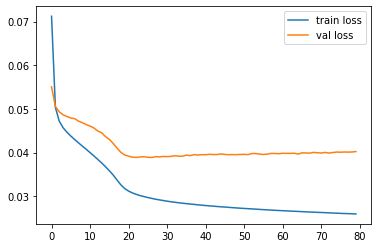

In [14]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

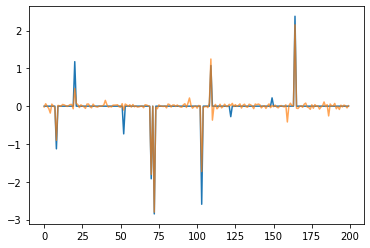

In [15]:
plt.plot(beta0)
plt.plot(predict(md_base, (Y0-mean)/std).reshape(-1), alpha=0.7)
plt.show()

In [16]:
torch.manual_seed(0)
md_withXY = MLP(N+p, p).to(device)
train_losses, val_losses = train_model(md_withXY, 0.001, 256, 80, Y_catXY_train, beta_train, val_data=Y_catXY_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.07258
Val loss: 0.05925
Epoch: 2
Train loss: 0.05507
Val loss: 0.05528
Epoch: 3
Train loss: 0.05228
Val loss: 0.05388
Epoch: 4
Train loss: 0.05047
Val loss: 0.05263
Epoch: 5
Train loss: 0.04872
Val loss: 0.05093
Epoch: 6
Train loss: 0.04685
Val loss: 0.04940
Epoch: 7
Train loss: 0.04467
Val loss: 0.04712
Epoch: 8
Train loss: 0.04222
Val loss: 0.04461
Epoch: 9
Train loss: 0.03986
Val loss: 0.04288
Epoch: 10
Train loss: 0.03875
Val loss: 0.04250
Epoch: 11
Train loss: 0.03820
Val loss: 0.04242
Epoch: 12
Train loss: 0.03779
Val loss: 0.04242
Epoch: 13
Train loss: 0.03746
Val loss: 0.04216
Epoch: 14
Train loss: 0.03719
Val loss: 0.04197
Epoch: 15
Train loss: 0.03693
Val loss: 0.04178
Epoch: 16
Train loss: 0.03669
Val loss: 0.04168
Epoch: 17
Train loss: 0.03646
Val loss: 0.04142
Epoch: 18
Train loss: 0.03621
Val loss: 0.04114
Epoch: 19
Train loss: 0.03598
Val loss: 0.04079
Epoch: 20
Train loss: 0.03573
Val loss: 0.04040
Epoch: 21
Train loss: 0.03550
Val loss: 0.04008
E

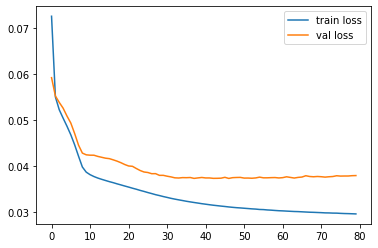

In [17]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [ ]:
plt.plot(beta0)
plt.plot(predict(md_withXY, (Y0_catXY-mean_catXY)/std_catXY).reshape(-1), alpha=0.7)
plt.show()

## Only use sample once

In [24]:
torch.manual_seed(0)
rng.seed(3)
md_base_online = MLP(N, p).to(device)
train_losses, val_losses = train_model_with_generator(md_base_online, generator, 0.001, 256, 200, 3000, False, val_data=Y_val, val_labels=beta_val)

Epoch: 1, Train loss 0.07663
Val loss: 0.05786
Epoch: 2, Train loss 0.05245
Val loss: 0.05018
Epoch: 3, Train loss 0.04845
Val loss: 0.04857
Epoch: 4, Train loss 0.04714
Val loss: 0.04722
Epoch: 5, Train loss 0.04614
Val loss: 0.04632
Epoch: 6, Train loss 0.04549
Val loss: 0.04580
Epoch: 7, Train loss 0.04473
Val loss: 0.04510
Epoch: 8, Train loss 0.04413
Val loss: 0.04449
Epoch: 9, Train loss 0.04346
Val loss: 0.04385
Epoch: 10, Train loss 0.04292
Val loss: 0.04310
Epoch: 11, Train loss 0.04234
Val loss: 0.04293
Epoch: 12, Train loss 0.04171
Val loss: 0.04231
Epoch: 13, Train loss 0.04118
Val loss: 0.04133
Epoch: 14, Train loss 0.04063
Val loss: 0.04094
Epoch: 15, Train loss 0.04011
Val loss: 0.04047
Epoch: 16, Train loss 0.03967
Val loss: 0.03996
Epoch: 17, Train loss 0.03921
Val loss: 0.03943
Epoch: 18, Train loss 0.03885
Val loss: 0.03934
Epoch: 19, Train loss 0.03837
Val loss: 0.03882
Epoch: 20, Train loss 0.03807
Val loss: 0.03881
Epoch: 21, Train loss 0.03771
Val loss: 0.03813
E

In [27]:
torch.save(md_base_online.state_dict(), './model/md_base_online.pt')

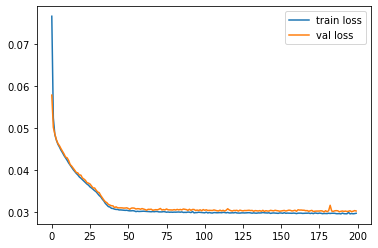

In [25]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

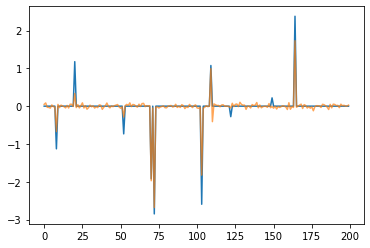

In [26]:
plt.plot(beta0)
plt.plot(predict(md_base_online, (Y0-mean)/std).reshape(-1), alpha=0.7)
plt.show()

## Quantile regression

In [56]:
torch.manual_seed(0)
md_q025 = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q025, 0.001, 256, 100, Y_train, beta_train, loss_type='quantile', q=0.025, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.01616
Val loss: 0.01218
Epoch: 2
Train loss: 0.01153
Val loss: 0.01147
Epoch: 3
Train loss: 0.01100
Val loss: 0.01119
Epoch: 4
Train loss: 0.01071
Val loss: 0.01091
Epoch: 5
Train loss: 0.01048
Val loss: 0.01072
Epoch: 6
Train loss: 0.01027
Val loss: 0.01053
Epoch: 7
Train loss: 0.01008
Val loss: 0.01042
Epoch: 8
Train loss: 0.00991
Val loss: 0.01024
Epoch: 9
Train loss: 0.00978
Val loss: 0.01012
Epoch: 10
Train loss: 0.00968
Val loss: 0.01005
Epoch: 11
Train loss: 0.00960
Val loss: 0.01001
Epoch: 12
Train loss: 0.00953
Val loss: 0.01008
Epoch: 13
Train loss: 0.00947
Val loss: 0.00987
Epoch: 14
Train loss: 0.00941
Val loss: 0.00988
Epoch: 15
Train loss: 0.00937
Val loss: 0.00981
Epoch: 16
Train loss: 0.00932
Val loss: 0.00977
Epoch: 17
Train loss: 0.00928
Val loss: 0.00979
Epoch: 18
Train loss: 0.00925
Val loss: 0.00972
Epoch: 19
Train loss: 0.00922
Val loss: 0.00974
Epoch: 20
Train loss: 0.00920
Val loss: 0.00967
Epoch: 21
Train loss: 0.00918
Val loss: 0.00970
E

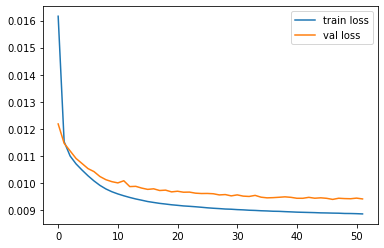

In [57]:
show_loss(train_losses, val_losses)

In [58]:
torch.manual_seed(0)
md_q975 = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q975, 0.001, 256, 100, Y_train, beta_train, loss_type='quantile', q=0.975, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.01638
Val loss: 0.01198
Epoch: 2
Train loss: 0.01151
Val loss: 0.01128
Epoch: 3
Train loss: 0.01099
Val loss: 0.01102
Epoch: 4
Train loss: 0.01071
Val loss: 0.01082
Epoch: 5
Train loss: 0.01049
Val loss: 0.01060
Epoch: 6
Train loss: 0.01029
Val loss: 0.01047
Epoch: 7
Train loss: 0.01009
Val loss: 0.01023
Epoch: 8
Train loss: 0.00992
Val loss: 0.01006
Epoch: 9
Train loss: 0.00978
Val loss: 0.00997
Epoch: 10
Train loss: 0.00966
Val loss: 0.00985
Epoch: 11
Train loss: 0.00957
Val loss: 0.00978
Epoch: 12
Train loss: 0.00949
Val loss: 0.00971
Epoch: 13
Train loss: 0.00943
Val loss: 0.00966
Epoch: 14
Train loss: 0.00938
Val loss: 0.00967
Epoch: 15
Train loss: 0.00933
Val loss: 0.00959
Epoch: 16
Train loss: 0.00930
Val loss: 0.00964
Epoch: 17
Train loss: 0.00927
Val loss: 0.00954
Epoch: 18
Train loss: 0.00924
Val loss: 0.00959
Epoch: 19
Train loss: 0.00922
Val loss: 0.00954
Epoch: 20
Train loss: 0.00919
Val loss: 0.00945
Epoch: 21
Train loss: 0.00917
Val loss: 0.00951
E

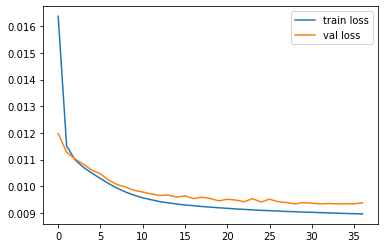

In [59]:
show_loss(train_losses, val_losses)

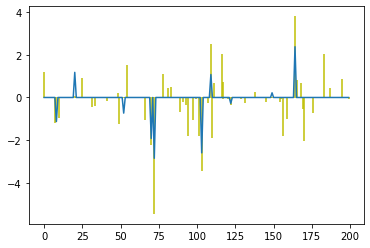

In [66]:
pred_q025 = predict(md_q025, (Y0-mean)/std)
pred_q975 = predict(md_q975, (Y0-mean)/std)
plt.plot(range(p), beta0)
plt.vlines(range(p), pred_q025.reshape(-1), pred_q975.reshape(-1), color='y')
plt.show()

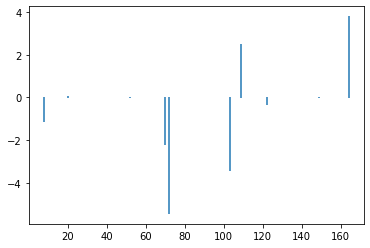

[-1.1463912  -0.02106796 -0.01421247 -2.2372198  -5.4608927  -3.4413683
 -0.01271686 -0.33062947 -0.02939109 -0.01811018]
[2.8926288e-03 8.3886757e-02 1.0510048e-02 4.6508368e-03 2.1981319e-02
 1.7855745e-02 2.4907720e+00 2.0112829e-02 2.1891978e-02 3.8098912e+00]


In [71]:
plt.vlines(np.where(beta0!=0)[0], pred_q025.reshape(-1)[np.where(beta0!=0)[0]], pred_q975.reshape(-1)[np.where(beta0!=0)[0]])
plt.show()
print(pred_q025.reshape(-1)[np.where(beta0!=0)[0]])
print(pred_q975.reshape(-1)[np.where(beta0!=0)[0]])

## Classification

In [40]:
torch.manual_seed(0)
md_classify_base = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_classify_base, 0.001, 256, 80, Y_train, gamma_train, loss_type="bce", val_data=Y_val, val_labels=gamma_val)

Epoch: 1
Train loss: 0.16070
Val loss: 0.14216
Epoch: 2
Train loss: 0.13803
Val loss: 0.13706
Epoch: 3
Train loss: 0.13399
Val loss: 0.13473
Epoch: 4
Train loss: 0.13096
Val loss: 0.13231
Epoch: 5
Train loss: 0.12788
Val loss: 0.13000
Epoch: 6
Train loss: 0.12540
Val loss: 0.12820
Epoch: 7
Train loss: 0.12354
Val loss: 0.12711
Epoch: 8
Train loss: 0.12220
Val loss: 0.12645
Epoch: 9
Train loss: 0.12120
Val loss: 0.12629
Epoch: 10
Train loss: 0.12040
Val loss: 0.12624
Epoch: 11
Train loss: 0.11973
Val loss: 0.12629
Epoch: 12
Train loss: 0.11919
Val loss: 0.12620
Epoch: 13
Train loss: 0.11870
Val loss: 0.12616
Epoch: 14
Train loss: 0.11826
Val loss: 0.12639
Epoch: 15
Train loss: 0.11788
Val loss: 0.12644
Epoch: 16
Train loss: 0.11750
Val loss: 0.12635
Epoch: 17
Train loss: 0.11716
Val loss: 0.12658
Epoch: 18
Train loss: 0.11684
Val loss: 0.12668


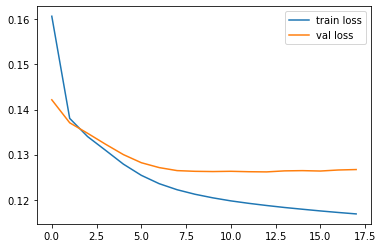

In [41]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [42]:
model_test(md_classify_base, Y_test, gamma_test, loss_type='bce')

0.12611381709575653

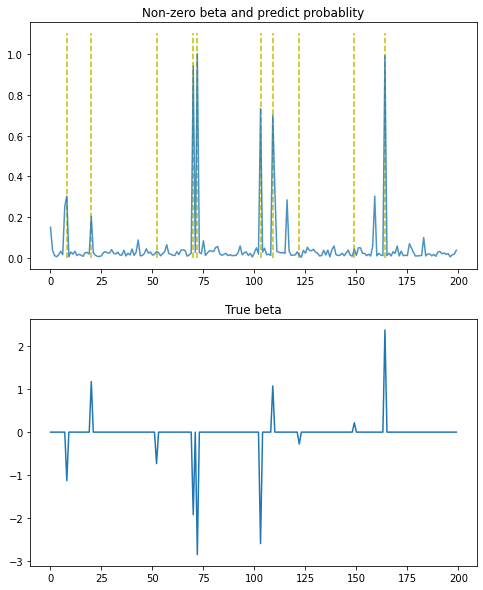

In [113]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.vlines(np.where(gamma0!=0)[0], 0, 1.1, linestyles='dashed', colors='y')
plt.plot(range(p),predict_class(md_classify_base, (Y0-mean)/std).reshape(-1), alpha=0.8)
plt.title('Non-zero beta and predict probablity')
plt.subplot(2, 1, 2)
plt.plot(beta0)
plt.title('True beta')
plt.show()

## Focus on a subset of features

In [44]:
torch.manual_seed(0)
md_subset10_base = MLP(N, 10).to(device)
train_losses, val_losses = train_model(md_subset10_base, 0.001, 256, 200, Y_train, beta_train[:,:10], val_data=Y_val, val_labels=beta_val[:,:10])

Epoch: 1
Train loss: 0.06947
Val loss: 0.06681
Epoch: 2
Train loss: 0.06195
Val loss: 0.06432
Epoch: 3
Train loss: 0.05873
Val loss: 0.06287
Epoch: 4
Train loss: 0.05614
Val loss: 0.06231
Epoch: 5
Train loss: 0.05383
Val loss: 0.06160
Epoch: 6
Train loss: 0.05165
Val loss: 0.06139
Epoch: 7
Train loss: 0.04962
Val loss: 0.06160
Epoch: 8
Train loss: 0.04782
Val loss: 0.06127
Epoch: 9
Train loss: 0.04614
Val loss: 0.06133
Epoch: 10
Train loss: 0.04459
Val loss: 0.06230
Epoch: 11
Train loss: 0.04321
Val loss: 0.06221
Epoch: 12
Train loss: 0.04196
Val loss: 0.06397
Epoch: 13
Train loss: 0.04078
Val loss: 0.06402


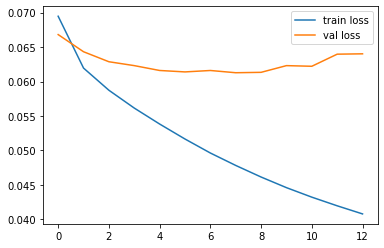

In [46]:
show_loss(train_losses, val_losses)

In [49]:
torch.manual_seed(0)
md_subset1_base = MLP(N, 1).to(device)
train_losses, val_losses = train_model(md_subset1_base, 0.001, 256, 200, Y_train, beta_train[:,:1], val_data=Y_val, val_labels=beta_val[:,:1], early_stop=10)

Epoch: 1
Train loss: 0.07031
Val loss: 0.06140
Epoch: 2
Train loss: 0.06247
Val loss: 0.06034
Epoch: 3
Train loss: 0.05893
Val loss: 0.05840
Epoch: 4
Train loss: 0.05608
Val loss: 0.05619
Epoch: 5
Train loss: 0.05352
Val loss: 0.05715
Epoch: 6
Train loss: 0.05098
Val loss: 0.05768
Epoch: 7
Train loss: 0.04865
Val loss: 0.05674
Epoch: 8
Train loss: 0.04643
Val loss: 0.05820
Epoch: 9
Train loss: 0.04457
Val loss: 0.05699
Epoch: 10
Train loss: 0.04301
Val loss: 0.05842
Epoch: 11
Train loss: 0.04148
Val loss: 0.05679
Epoch: 12
Train loss: 0.04025
Val loss: 0.05893
Epoch: 13
Train loss: 0.03911
Val loss: 0.05486
Epoch: 14
Train loss: 0.03809
Val loss: 0.05884
Epoch: 15
Train loss: 0.03683
Val loss: 0.05952
Epoch: 16
Train loss: 0.03588
Val loss: 0.05767
Epoch: 17
Train loss: 0.03480
Val loss: 0.06182
Epoch: 18
Train loss: 0.03407
Val loss: 0.06017
Epoch: 19
Train loss: 0.03325
Val loss: 0.05983
Epoch: 20
Train loss: 0.03233
Val loss: 0.05729
Epoch: 21
Train loss: 0.03161
Val loss: 0.05791
E

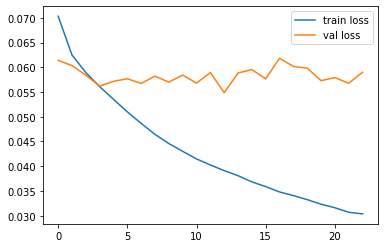

In [50]:
show_loss(train_losses, val_losses)

# Some efforts we have made but doesn't work
* Add shrink activation function to the output layer. It's impossible to train the model when using softshrink or hardshrink. Tanhshrink doesn't imporve the model's performance.